# Spherical Gaussian experiment (2D)

## Setup

In [1]:
import sys
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import torch
from torch.utils.data import TensorDataset
import logging


sys.path.append("../../")
import manifold_flow as mf
from manifold_flow import transforms, utils, flows, distributions, training
from manifold_flow import nn as nn_
from experiments.simulators.spherical_simulator import SphericalGaussianSimulator
from experiments.utils import vector_transforms

%matplotlib inline

logging.basicConfig(
    format="%(asctime)-5.5s %(name)-30.30s %(levelname)-7.7s %(message)s",
    datefmt="%H:%M",
    level=logging.DEBUG,
)
logger = logging.getLogger(__name__)
# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "experiments" not in key and "manifold_flow" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)


### Settings

In [2]:
epochs = 20
n_train = 100000
epsilon = 0.01

### Data

In [3]:
simulator = SphericalGaussianSimulator(latent_dim=1, data_dim=2, epsilon=epsilon)
x = simulator.sample(n_train)
x_tensor = torch.from_numpy(x)
train_dataset = TensorDataset(x_tensor, x_tensor)

11:50 experiments.simulators.spheric DEBUG   Evaluating true log density for x = [-1.4 -1.4]
11:50 experiments.simulators.spheric DEBUG   Latent variables: z_phi = [3.92699082], z_eps = [0.97989899]
../../experiments/simulators/spherical_simulator.py:108: RuntimeWarning: divide by zero encountered in log
  logp_eps = np.log(norm(loc=0.0, scale=self._epsilon).pdf(z_eps))


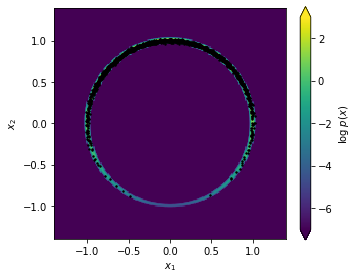

In [4]:
res = 200
x_range = np.linspace(-1.4,1.4,res)
y_range = np.linspace(-1.4,1.4,res)
xx, yy = np.meshgrid(x_range, y_range)
x_grid = np.concatenate((xx.reshape((-1,1)), yy.reshape((-1,1))), axis=1)
logp_grid = simulator.log_density(x_grid, precise=True).reshape((res, res))
logp_grid[~np.isfinite(logp_grid)] = -1000000.

zmin, zmax = np.max(logp_grid) - 10, np.max(logp_grid)
fig = plt.figure(figsize=(5,4))
ax = plt.gca()

pcm = plt.imshow(
    np.clip(logp_grid, zmin, zmax),
    extent=(-1.4,1.4,-1.4,1.4),
    origin="lower",
    cmap="viridis", norm=matplotlib.colors.Normalize(zmin, zmax),
    interpolation='nearest'
)
cb = plt.colorbar(pcm, extend="both")
plt.scatter(x[::50,0], x[::50,1], s=2., c="black", alpha=1.)

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
cb.set_label("$\log \; p(x)$")
plt.tight_layout()

plt.savefig("spherical_gaussian_2d_data.pdf", dpi=500)

In [5]:
pixel_size = (x_range[1] - x_range[0]) * (y_range[1] - y_range[0])

np.sum(np.exp(logp_grid) * pixel_size)

1.0000930850098504

## Set up models

### Manifold flow

In [18]:
outer_transform = vector_transforms.create_transform(
    2, 3,
    linear_transform_type="permutation",
    base_transform_type="affine-coupling",
    context_features=None,
    hidden_features=20,
    num_transform_blocks=1,
    resnet_transform=False,
)
inner_transform=transforms.ConditionalAffineScalarTransform(features=1)

mf = flows.manifold_flow.ManifoldFlow(
    data_dim=2,
    latent_dim=1,
    inner_transform=inner_transform,
    outer_transform=outer_transform
)

trainer = training.trainer.ManifoldFlowTrainer(mf)
trainer.train(
    train_dataset,
    [training.losses.mse, training.losses.nll],
    loss_weights=[100., 0.1],
    epochs=epochs // 2,
)
trainer.train(
    train_dataset,
    [training.losses.mse, training.losses.nll],
    loss_weights=[0., 1.],
    epochs=epochs // 2,
    parameters=mf.inner_transform.parameters()
)

13:57 manifold_flow.flows.manifold_f DEBUG   Set up projection from vector with dimension 2 to vector with dimension 1
13:57 manifold_flow.flows.manifold_f DEBUG   Created manifold flow with 0.0 M parameters (0.0 M trainable) with an estimated size of 0.0 GB
13:57 manifold_flow.training.trainer INFO    Training on CPU with single precision
13:57 manifold_flow.training.trainer DEBUG   Initialising training data
13:57 manifold_flow.training.trainer DEBUG   Setting up optimizer
13:57 manifold_flow.training.trainer DEBUG   Setting up LR scheduler
13:57 manifold_flow.training.trainer DEBUG   Using early stopping with infinite patience
13:57 manifold_flow.training.trainer DEBUG   Will print training progress every 1 epochs
13:57 manifold_flow.training.trainer DEBUG   Beginning main training loop
13:57 manifold_flow.training.trainer DEBUG   Training epoch 1 / 10
13:57 manifold_flow.training.trainer DEBUG     Learning rate: [0.001]
14:00 manifold_flow.training.trainer INFO    Epoch   1: train 

15:24 manifold_flow.training.trainer DEBUG     Learning rate: [9.549150281252633e-05]
15:27 manifold_flow.training.trainer INFO    Epoch  10: train loss -5.14841 (mse:  0.001, nll: -5.148)
15:27 manifold_flow.training.trainer INFO               val. loss  -5.14976 (mse:  0.001, nll: -5.150)
15:27 manifold_flow.training.trainer INFO    Early stopping did not improve performance
15:27 manifold_flow.training.trainer DEBUG   Training finished


(array([-4.79776785, -4.90539632, -4.98400068, -5.04110258, -5.08118783,
        -5.10850434, -5.12659272, -5.13806607, -5.14488169, -5.14840796]),
 array([-4.85862989, -4.95012907, -5.01698404, -5.06485654, -5.09767833,
        -5.11967753, -5.13398907, -5.14272019, -5.14758932, -5.14975608]))

### Standard flow

In [7]:
transform = vector_transforms.create_transform(
    2, 5,
    linear_transform_type="permutation",
    base_transform_type="affine-coupling",
    context_features=None
)
sf = flows.flow.Flow(
    data_dim=2,
    transform=transform
)

trainer = training.trainer.ManifoldFlowTrainer(sf)
trainer.train(
    train_dataset,
    [training.losses.nll],
    loss_weights=[1.],
    epochs=epochs,
)

12:56 manifold_flow.flows.flow       DEBUG   Created standard flow with 2.0 M parameters (2.0 M trainable) with an estimated size of 0.0 GB
12:56 manifold_flow.training.trainer INFO    Training on CPU with single precision
12:56 manifold_flow.training.trainer DEBUG   Initialising training data
12:56 manifold_flow.training.trainer DEBUG   Setting up optimizer
12:56 manifold_flow.training.trainer DEBUG   Setting up LR scheduler
12:56 manifold_flow.training.trainer DEBUG   Using early stopping with infinite patience
12:56 manifold_flow.training.trainer DEBUG   Will print training progress every 1 epochs
12:56 manifold_flow.training.trainer DEBUG   Beginning main training loop
12:56 manifold_flow.training.trainer DEBUG   Training epoch 1 / 20
12:56 manifold_flow.training.trainer DEBUG     Learning rate: [0.001]
12:57 manifold_flow.training.trainer INFO    Epoch   1: train loss  1.89993 (nll:  1.900)
12:57 manifold_flow.training.trainer INFO               val. loss   1.86207 (nll:  1.862)
1

(array([1.89993055, 1.87010498, 1.86470864, 1.86533288, 1.86278592,
        1.86104282, 1.86096088, 1.85968844, 1.85805645, 1.85769954,
        1.85680174, 1.85532773, 1.85496785, 1.85321598, 1.85222647,
        1.85223019, 1.85167489, 1.85119763, 1.84969025, 1.84913103]),
 array([1.862074  , 1.8703283 , 1.85772032, 1.86466637, 1.86612882,
        1.85729409, 1.85532889, 1.85439482, 1.85642943, 1.8548209 ,
        1.8555238 , 1.85232519, 1.85315354, 1.85075976, 1.85062023,
        1.84927719, 1.84909255, 1.85004399, 1.84798405, 1.84795922]))

### PIE

In [8]:
outer_transform = vector_transforms.create_transform(
    2, 5,
    linear_transform_type="permutation",
    base_transform_type="affine-coupling",
    context_features=None
)
inner_transform=transforms.ConditionalAffineScalarTransform(features=1)

pie = flows.pie.PIE(
    data_dim=2,
    latent_dim=1,
    outer_transform=outer_transform,
    inner_transform=inner_transform,
)

trainer = training.trainer.ManifoldFlowTrainer(pie)
trainer.train(
    train_dataset,
    [training.losses.nll],
    loss_weights=[1.],
    epochs=epochs,
)

13:21 manifold_flow.flows.pie        DEBUG   Set up projection from vector with dimension 2 to vector with dimension 1
13:21 manifold_flow.flows.pie        DEBUG   Created PIE with 2.0 M parameters (2.0 M trainable) with an estimated size of 0.0 GB
13:21 manifold_flow.training.trainer INFO    Training on CPU with single precision
13:21 manifold_flow.training.trainer DEBUG   Initialising training data
13:21 manifold_flow.training.trainer DEBUG   Setting up optimizer
13:21 manifold_flow.training.trainer DEBUG   Setting up LR scheduler
13:21 manifold_flow.training.trainer DEBUG   Using early stopping with infinite patience
13:21 manifold_flow.training.trainer DEBUG   Will print training progress every 1 epochs
13:21 manifold_flow.training.trainer DEBUG   Beginning main training loop
13:21 manifold_flow.training.trainer DEBUG   Training epoch 1 / 20
13:21 manifold_flow.training.trainer DEBUG     Learning rate: [0.001]
13:22 manifold_flow.training.trainer INFO    Epoch   1: train loss 2056.

(array([ 2.05605768e+03,  1.35957413e+02,  1.13585133e+02,  1.02325170e+02,
         8.83459515e+01,  9.99078359e+01,  1.79493102e+01,  1.53047884e+01,
         1.27915932e+01,  9.55684592e+00,  2.35335841e+01,  1.88514275e+01,
         1.28203619e+01,  8.81799358e+00,  5.08339572e+00,  2.52027493e+00,
         1.58292795e+00,  9.64532957e-01, -3.99907102e-01, -9.37492626e-01]),
 array([ 2.57980311e+02,  2.79355519e+02,  2.70057833e+02,  2.17141511e+02,
         1.51455229e+02,  1.35386763e+01,  1.48142346e+01,  1.59287743e+01,
         6.45498299e+00,  6.16292041e+00,  8.07325635e+00,  4.99019311e+00,
         2.79411292e+00,  6.41332727e+00,  3.72220571e+00,  2.10196743e-01,
         2.39391942e+00,  8.63449155e-01, -8.59732073e-01,  3.61113138e-01]))

## Evaluate the generative performance

### Sample

In [19]:
x_gen_sf = sf.sample(n=1000).detach().numpy()
x_gen_mf = mf.sample(n=1000).detach().numpy()
x_gen_pie = pie.sample(n=1000).detach().numpy()
x_gen_pie_full = pie.sample(n=1000, sample_orthogonal=True).detach().numpy()

### Distance from manifold, true likelihood of generated samples

In [20]:
logp_min = -1000

logp_gen_sf = simulator.log_density(x_gen_sf)
logp_gen_mf = simulator.log_density(x_gen_mf)
logp_gen_pie = simulator.log_density(x_gen_pie)
logp_gen_pie_full = simulator.log_density(x_gen_pie_full)

logp_gen_sf[(~np.isfinite(logp_gen_sf)) + (logp_gen_sf<logp_min)] = logp_min
logp_gen_mf[(~np.isfinite(logp_gen_mf)) + (logp_gen_mf<logp_min)] = logp_min
logp_gen_pie[(~np.isfinite(logp_gen_pie)) + (logp_gen_pie<logp_min)] = logp_min
logp_gen_pie_full[(~np.isfinite(logp_gen_pie_full)) + (logp_gen_pie_full<logp_min)] = logp_min

mean_logp_gen_sf = np.mean(logp_gen_sf)
mean_logp_gen_mf = np.mean(logp_gen_mf)
mean_logp_gen_pie = np.mean(logp_gen_pie)
mean_logp_gen_pie_full = np.mean(logp_gen_pie_full)

distance_from_manifold_gen_sf = np.mean(np.abs(np.sum(x_gen_sf**2, axis=1)**0.5 - 1))
distance_from_manifold_gen_mf = np.mean(np.abs(np.sum(x_gen_mf**2, axis=1)**0.5 - 1))
distance_from_manifold_gen_pie = np.mean(np.abs(np.sum(x_gen_pie**2, axis=1)**0.5 - 1))
distance_from_manifold_gen_pie_full = np.mean(np.abs(np.sum(x_gen_pie_full**2, axis=1)**0.5 - 1))

print("Mean true log likelihood of samples generated from flows (higher is better):")
print("  Standard flow:      {:>6.1f}".format(mean_logp_gen_sf))
print("  PIE:                {:>6.1f}".format(mean_logp_gen_pie))
print("  PIE (sampling all): {:>6.1f}".format(mean_logp_gen_pie_full))
print("  Manifold flow:      {:>6.1f}".format(mean_logp_gen_mf))

print("Mean Euclidean distance between samples generated from flows and true manifold (lower is better):")
print("  Standard flow:      {:>6.2f}".format(distance_from_manifold_gen_sf))
print("  PIE:                {:>6.2f}".format(distance_from_manifold_gen_pie))
print("  PIE (sampling all): {:>6.2f}".format(distance_from_manifold_gen_pie_full))
print("  Manifold flow:      {:>6.2f}".format(distance_from_manifold_gen_mf))


15:30 experiments.simulators.spheric DEBUG   Evaluating true log density for x = [-1.5615897  0.5231001]
15:30 experiments.simulators.spheric DEBUG   Latent variables: z_phi = [2.81836152], z_eps = [0.64687467]
../../experiments/simulators/spherical_simulator.py:108: RuntimeWarning: divide by zero encountered in log
  logp_eps = np.log(norm(loc=0.0, scale=self._epsilon).pdf(z_eps))
15:30 experiments.simulators.spheric DEBUG   Evaluating true log density for x = [-0.3619788   0.92473966]
15:30 experiments.simulators.spheric DEBUG   Latent variables: z_phi = [1.94390047], z_eps = [-0.00693804]
../../experiments/simulators/spherical_simulator.py:112: RuntimeWarning: divide by zero encountered in log
  np.arange(self._latent_dim - 1, -1, -1)[np.newaxis, :] * np.log(np.abs(np.sin(z_phi))),
../../experiments/simulators/spherical_simulator.py:112: RuntimeWarning: invalid value encountered in multiply
  np.arange(self._latent_dim - 1, -1, -1)[np.newaxis, :] * np.log(np.abs(np.sin(z_phi))),
15:

Mean true log likelihood of samples generated from flows (higher is better):
  Standard flow:      -715.1
  PIE:                -114.7
  PIE (sampling all): -133.3
  Manifold flow:       -21.4
Mean Euclidean distance between samples generated from flows and true manifold (lower is better):
  Standard flow:        1.51
  PIE:                 15.70
  PIE (sampling all):  16.10
  Manifold flow:        0.03


/Users/johannbrehmer/anaconda3/envs/ml/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in less
  if __name__ == '__main__':


### Visualize generated samples

15:30 experiments.simulators.spheric DEBUG   Evaluating true log density for x = [-1.5 -1.5]
15:30 experiments.simulators.spheric DEBUG   Latent variables: z_phi = [3.92699082], z_eps = [1.12132034]


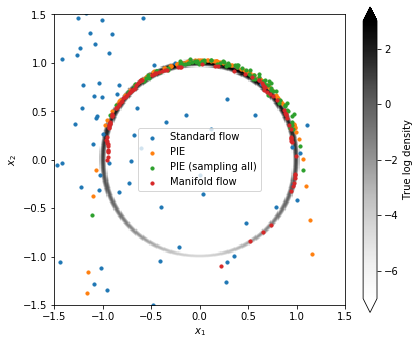

In [21]:
skip = 10
res = 250
x_range = np.linspace(-1.5,1.5,res)
y_range = np.linspace(-1.5,1.5,res)
xx, yy = np.meshgrid(x_range, y_range)
x_grid = np.concatenate((xx.reshape((-1,1)), yy.reshape((-1,1))), axis=1)
logp_grid = simulator.log_density(x_grid).reshape((res, res))
logp_grid[~np.isfinite(logp_grid)] = -1000000.
zmin, zmax = np.max(logp_grid) - 10., np.max(logp_grid)

fig = plt.figure(figsize=(6,5))
ax = plt.gca()

pcm = plt.imshow(
    np.clip(logp_grid, zmin, zmax),
    extent=(-1.5,1.5,-1.5,1.5),
    origin="lower",
    cmap="Greys",
    norm=matplotlib.colors.Normalize(zmin, zmax),
    interpolation='nearest'
)
cb = plt.colorbar(pcm, extend="both")

plt.scatter(x_gen_sf[::skip,0], x_gen_sf[::skip,1], s=10., c="C0", label="Standard flow")
plt.scatter(x_gen_pie[::skip,0], x_gen_pie[::skip,1], s=10., c="C1", label="PIE")
plt.scatter(x_gen_pie_full[::skip,0], x_gen_pie_full[::skip,1], s=10., c="C2", label="PIE (sampling all)")
plt.scatter(x_gen_mf[::skip,0], x_gen_mf[::skip,1], s=10., c="C3", label="Manifold flow")

plt.legend()

plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
cb.set_label("True log density")

plt.tight_layout()
plt.savefig("spherical_gaussian_2d_generation.pdf")


## Visualize learned likelihoods

### Log likelihood

In [22]:
res = 100
x_range = np.linspace(-1.5,1.5,res)
y_range = np.linspace(-1.5,1.5,res)
xx, yy = np.meshgrid(x_range, y_range)
x_grid = np.concatenate((xx.reshape((-1,1)), yy.reshape((-1,1))), axis=1)
x_grid_tensor = torch.FloatTensor(x_grid)

learned_logp_grid_mf = mf.log_prob(x_grid_tensor).detach().numpy().reshape((res, res))
learned_logp_grid_sf = sf.log_prob(x_grid_tensor).detach().numpy().reshape((res, res))
learned_logp_grid_pie = pie.log_prob(x_grid_tensor).detach().numpy().reshape((res, res))
logp_grid_truth = simulator.log_density(x_grid).reshape((res, res))
logp_grid_truth[~np.isfinite(logp_grid_truth)] = -1000000.


15:32 experiments.simulators.spheric DEBUG   Evaluating true log density for x = [-1.5 -1.5]
15:32 experiments.simulators.spheric DEBUG   Latent variables: z_phi = [3.92699082], z_eps = [1.12132034]
../../experiments/simulators/spherical_simulator.py:108: RuntimeWarning: divide by zero encountered in log
  logp_eps = np.log(norm(loc=0.0, scale=self._epsilon).pdf(z_eps))


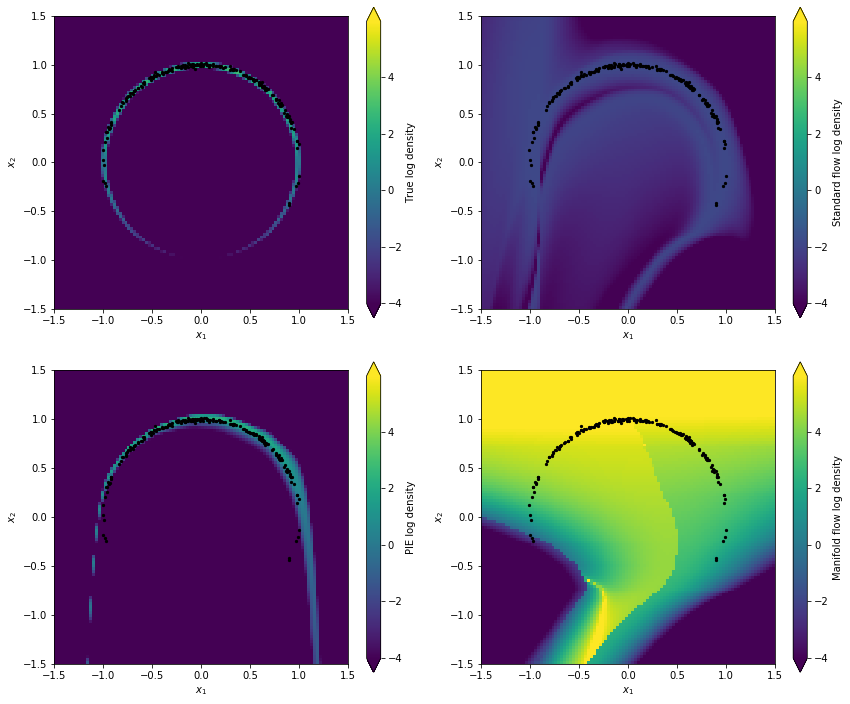

In [31]:
skip = 500

fig = plt.figure(figsize=(12,10))

for i, (label, logp) in enumerate(zip(
    ["True log density", "Standard flow log density", "PIE log density", "Manifold flow log density"],
    [logp_grid_truth, learned_logp_grid_sf, learned_logp_grid_pie, learned_logp_grid_mf]
     )):
    ax = plt.subplot(2,2,i+1)

    zmin, zmax = np.max(logp_grid_truth) - 7., np.max(logp_grid_truth) + 3.

    pcm = plt.imshow(
        np.clip(logp, zmin, zmax),
        extent=(-1.5, 1.5, -1.5, 1.5),
        origin="lower",
        cmap="viridis",
        norm=matplotlib.colors.Normalize(zmin, zmax),
        interpolation='nearest'
    )
    cb = plt.colorbar(pcm, extend="both")
    plt.scatter(x[::skip,0], x[::skip,1], s=5., c="black")

    plt.xlim(-1.5,1.5)
    plt.ylim(-1.5,1.5)
    plt.xlabel("$x_1$")
    plt.ylabel("$x_2$")
    cb.set_label(label)
    
plt.tight_layout()
plt.savefig("spherical_gaussian_2d_log_prob.pdf", dpi=600)


## More visualizations

### Reconstruction

In [24]:
x_in = SphericalGaussianSimulator(1,2,epsilon=epsilon).sample(100)
x_in = torch.FloatTensor(x_in)
x_out = mf(x_in)[0]
x_in, x_out = x_in.detach().numpy(), x_out.detach().numpy()
dx = x_out - x_in

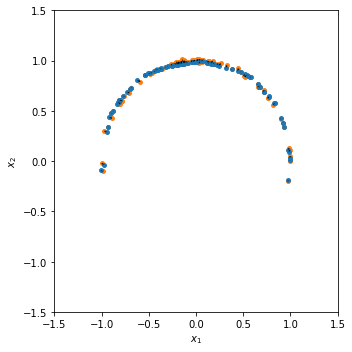

In [25]:
fig = plt.figure(figsize=(5,5))
ax = plt.gca()
plt.scatter(x_in[:,0], x_in[:,1], s=15., c="C1")
plt.scatter(x_out[:,0], x_out[:,1], s=15., c="C0")
plt.quiver(
    x_in[:,0], x_in[:,1], dx[:,0], dx[:,1],
    angles='xy', scale_units='xy', scale=1., width=2.e-3, alpha=1.
)

plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.tight_layout()

plt.savefig("spherical_gaussian_2d_reconstruction.pdf")


### Latent variables

In [36]:
u

array([[-6.797843  ],
       [-6.4119573 ],
       [-6.0260706 ],
       ...,
       [ 0.24936199],
       [ 0.25155735],
       [ 0.2537527 ]], dtype=float32)

In [33]:
res = 51
x_range = np.linspace(-1.5,1.5,res)
y_range = np.linspace(-1.5,1.5,res)
xx, yy = np.meshgrid(x_range, y_range)
x_grid = np.concatenate((xx.reshape((-1,1)), yy.reshape((-1,1))), axis=1)
x_grid_tensor = torch.FloatTensor(x_grid)

_, _, u = mf(x_grid_tensor)
u = u.detach().numpy()


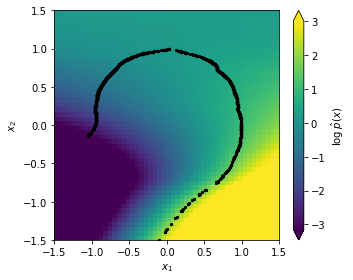

In [38]:
zmin, zmax = np.mean(u) - np.std(u), np.mean(u) + np.std(u)
fig = plt.figure(figsize=(5,4))
ax = plt.gca()

pcm = plt.pcolormesh(
    x_range, y_range,
    np.clip(np.clip(u, zmin, zmax).reshape(res, res), zmin, zmax),
    cmap="viridis", norm=matplotlib.colors.Normalize(zmin, zmax)
)
cb = plt.colorbar(pcm, extend="both")
plt.scatter(x_gen_mf[:,0], x_gen_mf[:,1], s=5., c="black")

plt.xlim(-1.5,1.5)
plt.ylim(-1.5,1.5)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
cb.set_label("$\log \; \hat{p}(x)$")
plt.tight_layout()

plt.savefig("spherical_gaussian_2d_latent.pdf")